# Window Splitters in Sktime

In this notebook we describe the window splitters included in the [`sktime.forecasting.model_selection`](https://github.com/alan-turing-institute/sktime/blob/main/sktime/forecasting/model_selection/_split.py) module. These splitters can be combined with `ForecastingGridSearchCV` for model selection (see [forecasting notebook](https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb)). 

**Remark:** It is important to emphasize that for cross-validation in time series we can not randomly shuffle the data as we would be leaking information.

**References:**
- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
- [Cross-validation for time series](https://robjhyndman.com/hyndsight/tscv/)

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

## Data

We use a fraction of the Box-Jenkins univariate airline data set, which shows the number of international airline passengers per month from 1949 - 1960. 

In [2]:
# We are interested on a portion of the total data set.
# (for visualisatiion purposes)
y = load_airline().iloc[:30]
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

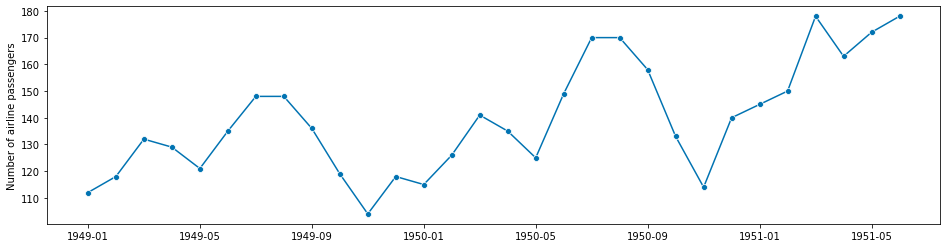

In [3]:
fig, ax = plot_series(y)

## Window Splitters

Now we describe each of the splitters.  

### A single train-test split using `temporal_train_test_split`

This one splits the data into a traininig and test sets. You can either (i) set the size of the training or test set or (ii) use a forecasting horizon.

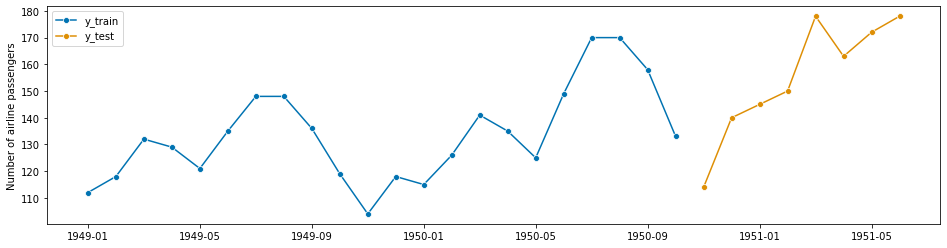

In [4]:
# setting test set size
y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])

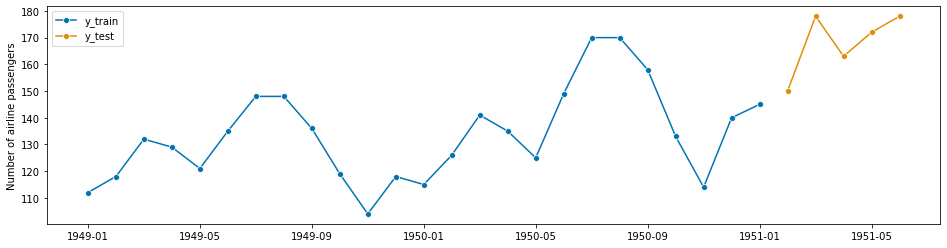

In [5]:
# using forecasting horizon
fh = ForecastingHorizon([1, 2, 3, 4, 5])
y_train, y_test = temporal_train_test_split(y, fh=fh)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

### Single split using `SingleWindowSplitter`

This class splits the time series once into a training and test window. Note that this is very similar to `temporal_train_test_split`.

Let us define the parameters of our fold:

In [6]:
# set splitter parameters
window_length = 10
fh = ForecastingHorizon([1, 2, 3])
fh_length = len(fh)

In [7]:
cv = SingleWindowSplitter(window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 1


Let us plot the unique fold generated. First we define some helper functions:

In [8]:
def get_folds_arrays(y, cv):
    """Store folds as arrays."""
    n_splits = cv.get_n_splits(y)

    windows = np.empty((n_splits, window_length), dtype=np.int)
    fhs = np.empty((n_splits, fh_length), dtype=np.int)

    for i, (w, f) in enumerate(cv.split(y)):
        windows[i] = w
        fhs[i] = f
    return windows, fhs


def get_y(length, split):
    """Creates a constant level vector based on the split."""
    return np.ones(length) * split

Now we generate the plot:

/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


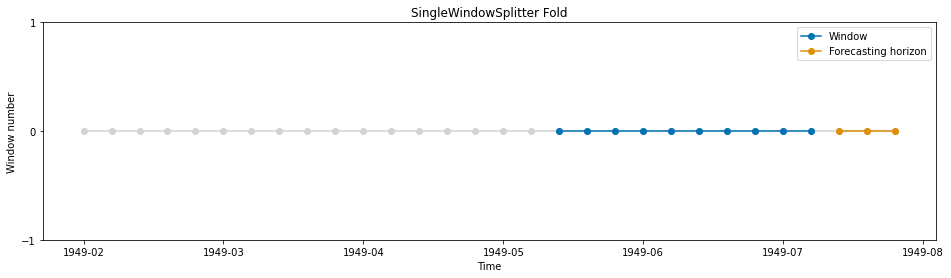

In [9]:
windows, fhs = get_folds_arrays(y, cv)

window_color, fh_color = sns.color_palette("colorblind")[:2]

fig, ax = plt.subplots(figsize=plt.figaspect(0.25))
for i in range(n_splits):
    ax.plot(np.arange(len(y)), get_y(len(y), i), marker="o", c="lightgray")
    ax.plot(
        windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window"
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="SingleWindowSplitter Fold",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
    ylim=(-1, 1),
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);

In [10]:
fhs

array([[27, 28, 29]])

In [11]:
windows

array([[17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

### Sliding windows using `SlidingWindowSplitter`

This splitter generates folds which move with time. The length of the training and test sets for each fold remains constant.

In [12]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 18


/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


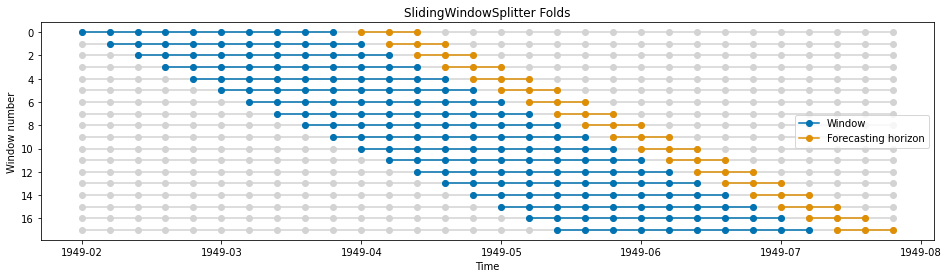

In [13]:
windows, fhs = get_folds_arrays(y, cv)

fig, ax = plt.subplots(figsize=plt.figaspect(0.25))
for i in range(n_splits):
    ax.plot(np.arange(len(y)), get_y(len(y), i), marker="o", c="lightgray")
    ax.plot(
        windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window"
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="SlidingWindowSplitter Folds",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);

### Expanding windows using `ExpandingWindowSplitter`

This splitter generates folds which move with time. The length of the training set each fold grows while test sets for each fold remains constant.

In [14]:
cv = ExpandingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 18


In [15]:
def get_expanding_window_arrays(y, cv):
    """Store folds as arrays."""
    n_splits = cv.get_n_splits(y)

    windows = []
    fhs = np.empty((n_splits, fh_length), dtype=np.int)

    for i, (w, f) in enumerate(cv.split(y)):
        windows.append(w)
        fhs[i] = f
    return windows, fhs

/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


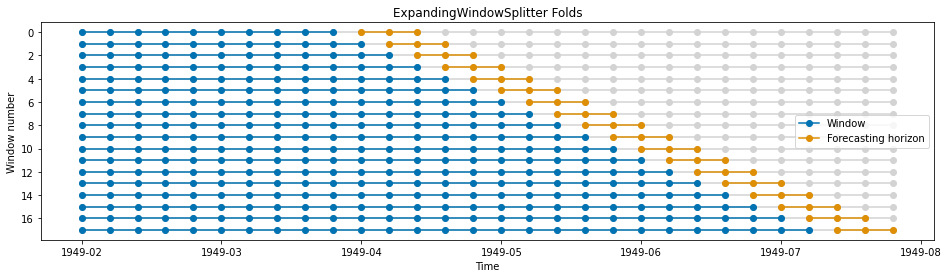

In [16]:
windows, fhs = get_expanding_window_arrays(y, cv)

fig, ax = plt.subplots(figsize=plt.figaspect(0.25))
for i in range(n_splits):
    ax.plot(np.arange(len(y)), get_y(len(y), i), marker="o", c="lightgray")
    ax.plot(
        windows[i],
        get_y(window_length + i, i),
        marker="o",
        c=window_color,
        label="Window",
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="ExpandingWindowSplitter Folds",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);

### Multiple splits at specific cutoff values - `CutoffSplitter`

With this splitter we can manually select the cutoff points.

In [17]:
# Specify cutoff points (by array index).
cutoffs = np.array([10, 11, 17, 23])

cv = CutoffSplitter(cutoffs=cutoffs, window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 4


In [18]:
windows, fhs = get_folds_arrays(y, cv)

/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


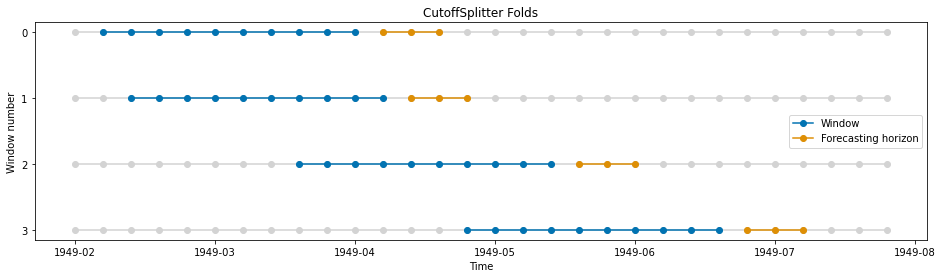

In [19]:
windows, fhs = get_folds_arrays(y, cv)

fig, ax = plt.subplots(figsize=plt.figaspect(0.25))
for i in range(n_splits):
    ax.plot(np.arange(len(y)), get_y(len(y), i), marker="o", c="lightgray")
    ax.plot(
        windows[i], get_y(window_length, i), marker="o", c=window_color, label="Window"
    )
    ax.plot(
        fhs[i], get_y(fh_length, i), marker="o", c=fh_color, label="Forecasting horizon"
    )
ax.invert_yaxis()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(
    title="CutoffSplitter Folds",
    ylabel="Window number",
    xlabel="Time",
    xticklabels=y.index,
)
# remove duplicate labels/handles
handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
ax.legend(handles, labels);

In [20]:
windows

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]])

In [21]:
fhs

array([[11, 12, 13],
       [12, 13, 14],
       [18, 19, 20],
       [24, 25, 26]])